In [11]:
!python -m pip install pyspark==2.4.6

In [1]:
import pandas

In [1]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext

In [2]:
conf = SparkConf()\
    .setAppName("Python Script for getting the table 'favorite foods'")\
    .setMaster("local[*]") \
    .set('spark.jars','spark-cassandra-connector-2.4.0-s_2.11.jar')

In [3]:
sc = SparkContext(conf=conf)

In [4]:
sqlContext = SQLContext(sc)

In [5]:
df = sqlContext.read.format("org.apache.spark.sql.cassandra")\
.options(table="all_channels", keyspace="final4").load()

In [17]:
from pyspark.sql import functions as F
train_data = df.where(F.col('channel_id') =='iribnews').\
groupby(F.col('date').alias('ds')).agg(F.count(F.lit(1)).alias("y")).sort('ds')


# train_data = df.groupby(F.col('date').alias('ds')).agg(F.count(F.lit(1)).alias("y")).sort('ds')

In [18]:
train_data = train_data.toPandas()

In [19]:
print(list(train_data['ds']))

['2020-08-10 09:09:00', '2020-08-10 09:30:00', '2020-08-10 09:39:00', '2020-08-10 09:44:00', '2020-08-10 09:49:00', '2020-08-10 10:01:00', '2020-08-10 10:04:00', '2020-08-10 10:16:00', '2020-08-10 10:31:00', '2020-08-10 10:46:00', '2020-08-10 10:55:00', '2020-08-10 11:10:00', '2020-08-10 11:20:00', '2020-08-10 11:26:00', '2020-08-10 11:32:00', '2020-08-10 11:33:00', '2020-08-10 11:57:00', '2020-08-11 12:06:00', '2020-08-11 12:54:00', '2020-08-11 13:07:00', '2020-08-11 13:25:00', '2020-08-12 07:10:00', '2020-08-12 07:23:00', '2020-08-12 07:33:00', '2020-08-12 07:47:00', '2020-08-12 08:02:00', '2020-08-12 08:13:00', '2020-08-12 08:27:00', '2020-08-12 08:40:00', '2020-08-12 08:47:00', '2020-08-12 08:56:00', '2020-08-12 10:02:00', '2020-08-12 10:13:00', '2020-08-12 10:23:00', '2020-08-12 10:47:00', '2020-08-12 11:04:00', '2020-08-12 11:22:00', '2020-08-12 11:33:00', '2020-08-12 11:47:00']


In [20]:
from datetime import datetime, timedelta
st = train_data.iloc[0]['ds']
en = train_data.iloc[len(train_data)-1]['ds']
def datetime_range(start, end, delta):
    current = start
    while current < end:
        yield current
        current += delta

# dts = [dt.strftime('%Y-%m-%d %H:%M:00') for dt in datetime_range(datetime(int(st[:4]),int(st[5:7]),int(st[8:10]),int(st[11:13])), datetime(int(en[:4]),int(en[5:7]),int(en[8:10]),int(en[11:13])+1),timedelta(minutes=1))]
dts = [dt.strftime('%Y-%m-%d %H:%M:00') for dt in datetime_range(datetime(2020,8,10,7), datetime(2020,8,12,12),timedelta(minutes=1))]

In [21]:
y=[0 for i in range(len(dts))]
for i in range(len(dts)):
    if dts[i] in list(train_data['ds']):
        y[i] = train_data[train_data['ds']==dts[i]]['y'].item()

In [22]:
import pandas as pd
# intialise data of lists. 
d = {'ds':dts, 'y':y} 
  
# Create DataFrame 
df_train = pd.DataFrame(d)

In [23]:
df1 = df_train[df_train['y']==0].sample(len(df_train[df_train['y']==0])-len(df_train[df_train['y']==1]))
df_train = df_train[~df_train.index.isin(df1.index)]

In [24]:
len(df_train[df_train['y']==1])

39

In [25]:
from fbprophet import Prophet
m = Prophet().fit(df_train)



INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
C:\Users\Fatemeh Saligheh\Anaconda3\lib\site-packages\fbprophet\forecaster.py:400: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  (dates - pd.datetime(1970, 1, 1))


In [26]:
future = m.make_future_dataframe(periods=3*24*60, freq='min', include_history =True)
fcst = m.predict(future)


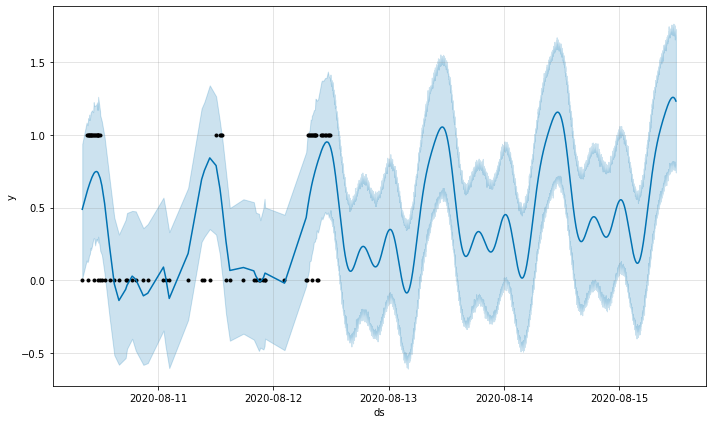

In [27]:
from matplotlib import pyplot
fig = m.plot(fcst)

In [28]:
fcst

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-08-10 08:15:00,0.096015,0.013495,0.937602,0.096015,0.096015,0.392628,0.392628,0.392628,0.392628,0.392628,0.392628,0.0,0.0,0.0,0.488644
1,2020-08-10 09:09:00,0.099839,0.137015,1.084295,0.099839,0.099839,0.498992,0.498992,0.498992,0.498992,0.498992,0.498992,0.0,0.0,0.0,0.598831
2,2020-08-10 09:21:00,0.100689,0.125728,1.066251,0.100689,0.100689,0.519898,0.519898,0.519898,0.519898,0.519898,0.519898,0.0,0.0,0.0,0.620587
3,2020-08-10 09:30:00,0.101326,0.139469,1.115791,0.101326,0.101326,0.535098,0.535098,0.535098,0.535098,0.535098,0.535098,0.0,0.0,0.0,0.636424
4,2020-08-10 09:39:00,0.101963,0.168738,1.104450,0.101963,0.101963,0.549855,0.549855,0.549855,0.549855,0.549855,0.549855,0.0,0.0,0.0,0.651819
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4393,2020-08-15 11:43:00,0.620571,0.776691,1.683913,0.620571,0.620571,0.617468,0.617468,0.617468,0.617468,0.617468,0.617468,0.0,0.0,0.0,1.238039
4394,2020-08-15 11:44:00,0.620642,0.795203,1.694748,0.620641,0.620642,0.616095,0.616095,0.616095,0.616095,0.616095,0.616095,0.0,0.0,0.0,1.236736
4395,2020-08-15 11:45:00,0.620712,0.790339,1.688571,0.620712,0.620712,0.614679,0.614679,0.614679,0.614679,0.614679,0.614679,0.0,0.0,0.0,1.235391
4396,2020-08-15 11:46:00,0.620783,0.741815,1.670862,0.620783,0.620783,0.613220,0.613220,0.613220,0.613220,0.613220,0.613220,0.0,0.0,0.0,1.234003
